In [2]:
%ls

clean_data.py*                        img/
cleaned_landsend_veg_2007_2012.csv*   landsend_veg_2007_2012.csv*
column_definition_helper_test.ipynb*  preprocess_diversity.ipynb*
Conservatory3.ipynb*                  README.md*
Conservatory4.ipynb*                  ShrubMix.R*
define_column.py*                     species_matching.R*
ideal_mix.json*                       stature_yr_site.ipynb*
ideal_species_mix.csv*                veg_2.R*
image.png*


**_combined from worksheets by @DLituiev, @jnaulty, @Omid Saremi_**

first import packages needed

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# color and style packages, thanks to  jnaulty
from mpltools import style
from mpltools import color
style.use('ggplot')

/usr/local/lib/python3.4/dist-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)


In [5]:
df = pd.read_csv("landsend_veg_2007_2012.csv")

split the `Site-YearCode` column into `site` and `year` columns

In [6]:
get_year = lambda x : int(x.split("-")[-1])
df["year"] = df["Site-YearCode"].map( get_year )

get_site = lambda x : (x.split("-")[0])
df["site"] = df["Site-YearCode"].map( get_site )

df.drop("Site-YearCode", axis=1, inplace = True)
df.head()

,Transect,Point,Height,Species,Plant code,Native Status,Life History,Stature,year,site
0,5,90,Low,-,-,-,-,-,2012,NUWO
1,13,150,Low,-,-,-,-,-,2012,NUWO
2,8,20,Low,Achillea millefolium,ACMI,Native,Perennial,Forb,2010,NMS
3,24,4,Low,Achillea millefolium,ACMI,Native,Perennial,Forb,2010,NMS
4,48,16,Low,Achillea millefolium,ACMI,Native,Perennial,Forb,2010,NMS


time points later than 2012 are typos according to Naomi, please delete them!

In [7]:
df = df.loc[df["year"] <= 2012]

 count the frequencies of species in the data set

In [8]:
species = df[["Species"]].copy()
species["counts"] = 1
species_freq = species.groupby("Species").agg(sum).iloc[:,0].copy()
species_freq.sort(ascending=False)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


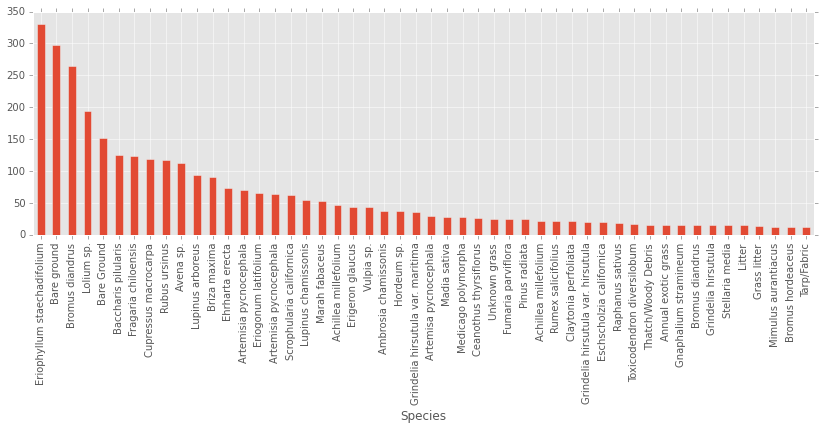

In [9]:
plt.figure(figsize=(14,4))
species_freq[:50].plot(kind = "bar")
pass

Extract the **columns** we need (`"Site-YearCode"`, `"Species"`), and take **rows** which have no missing values ("-")

In [10]:
df_yr_sp = df[["site", "year", "Species"]]
valid = ~ df_yr_sp.applymap( lambda x: x == "-").any(axis=1)
df_yr_sp = df_yr_sp.loc[valid]

**Grouping excersise**

toy example: iterate over site and year groups:

In [11]:
for kk, vv in df_yr_sp.groupby(["site", "year"]):
    print(kk, vv["Species"].unique().shape[0] )

('EAPO', 2011) 31
('NMS', 2010) 45
('NMS', 2011) 35
('NMS', 2012) 54
('NUWO', 2010) 54
('NUWO', 2011) 25
('NUWO', 2012) 47
('SUDU', 2008) 33
('SUDU', 2009) 40
('SUDU', 2010) 35
('SUDU', 2011) 31
('SUDU', 2012) 41


## Number of species per site per year

_group_

In [12]:
site_yr_spnum = df_yr_sp.groupby(["site", "year"]).agg("count")["Species"]
site_yr_spnum.head()

site  year
EAPO  2011    390
NMS   2010    247
      2011    175
      2012    335
NUWO  2010    320
Name: Species, dtype: int64

_pivot_

In [13]:
spnum_xt = pd.pivot_table( site_yr_spnum.reset_index() , index = "year", columns= "site")["Species"]#.fillna(0)
spnum_xt

site,EAPO,NMS,NUWO,SUDU
year,,,,
2008,NaN,NaN,NaN,498
2009,NaN,NaN,NaN,505
2010,NaN,247,320,222
2011,390,175,115,177
2012,NaN,335,400,200


_plot_

In [14]:
def plot_df_xt(df , title = "",  xlims = (2008, 2012), loc = "lower left", ylabel = ""):
    
    plt.plot(df.index.tolist(), df, ".-", 
             lw = 3, markeredgecolor = None, markersize = 18)

    x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
    plt.gca().xaxis.set_major_formatter(x_formatter)
    plt.xticks(range(xlims[0], xlims[-1]+1))
    
    plt.xlim(xlims)
    
    oomo = lambda x: 10**np.floor(np.log10(x))
    roundup = lambda x: oomo(x)*np.ceil( x / oomo(x))
    plt.ylim((0, roundup(np.nanmax(df)) ))
        
    plt.xlabel("year", fontsize = 12)
    plt.ylabel(ylabel)
    plt.title(title, fontsize = 16)
    plt.legend( df.columns.tolist(), loc = loc)
    return

In [15]:
sites = spnum_xt.notnull().sum().sort_values(ascending = False).index.tolist()
sites

['SUDU', 'NUWO', 'NMS', 'EAPO']

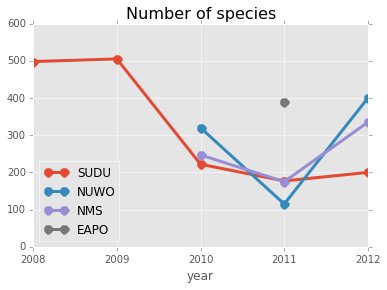

In [16]:
plot_df_xt(spnum_xt[sites], title = "Number of species")

## Counts of each spicies per site per year

_group_

In [17]:
df_yr_sp["count"] = 1

df_site_sp_yr = df_yr_sp.\
groupby(["site", "year",  "Species",]).agg("count").\
reset_index().set_index("site")

df_site_sp_yr.loc["SUDU"].head()

,year,Species,count
site,,,
SUDU,2008,Abronia latifolia,5
SUDU,2008,Achillea millefolium,12
SUDU,2008,Ambrosia chamissonis,14
SUDU,2008,Artemisia californica,1
SUDU,2008,Artemisia pycnocephala,67


_pivoting_

In [18]:
dfpiv_sudu = pd.pivot_table(
    df_site_sp_yr.loc["SUDU"],
    index = "Species", columns = "year").fillna(0)["count"]

dfpiv_sudu.head()

year,2008,2009,2010,2011,2012
Species,,,,,
Abronia latifolia,5,1,1,0,1
Achillea millefolium,0,0,5,4,5
Achillea millefolium,12,10,0,0,0
Albizia lophantha,0,1,1,0,1
Ambrosia chamissonis,14,11,7,1,4


In [19]:
def shannon(dfpiv):
    f = (dfpiv/dfpiv.sum())
    return   -(f*np.log2(f)).sum()

def simpson(dfpiv):
    f = (dfpiv/dfpiv.sum())
    return (f**2).sum()

In [20]:
index_yr = sorted(df_site_sp_yr["year"].unique().tolist())
shannon_xt = pd.DataFrame(index = index_yr, columns = sites)
simpson_xt = pd.DataFrame(index = index_yr, columns = sites)


for site in sites:
    dfpiv = pd.pivot_table(
        df_site_sp_yr.loc[site],
        index = "Species", columns = "year").fillna(0)["count"]
    
    shannon_xt[site] = shannon(dfpiv)
    simpson_xt[site] = simpson(dfpiv)

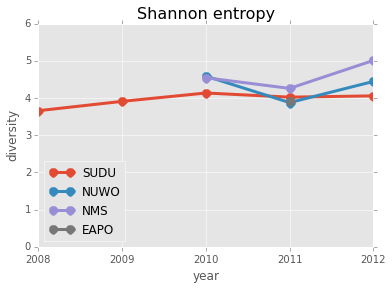

In [21]:
plot_df_xt(shannon_xt,  xlims = (2008, 2012), title = "Shannon entropy", ylabel = "diversity")

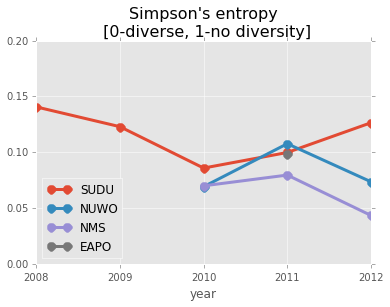

In [22]:
plot_df_xt(simpson_xt, xlims = (2008, 2012), 
           title = "Simpson's entropy\n [0-diverse, 1-no diversity]")

## species composition on Sutro Dunes over years

In [23]:
cols = ["Species","year", "site"]
valid = (df_yr_sp["site"] =="SUDU")

dfpiv_all = pd.pivot_table(
    df_yr_sp.loc[valid].groupby(cols).agg("count").reset_index().\
    drop("site", axis = 1).groupby(["Species","year"]).\
    agg(sum).reset_index(), index = "Species", columns = "year").\
        fillna(0)["count"]

dfpiv_all.head()

year,2008,2009,2010,2011,2012
Species,,,,,
Abronia latifolia,5,1,1,0,1
Achillea millefolium,0,0,5,4,5
Achillea millefolium,12,10,0,0,0
Albizia lophantha,0,1,1,0,1
Ambrosia chamissonis,14,11,7,1,4


In [24]:
ordering = dfpiv_all.sum(axis=1).copy()
ordering.sort(ascending=False)
ordering.head(20)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from IPython.kernel.zmq import kernelapp as app


Species
Eriophyllum staechadifolium          293
Bare ground                          178
Bare Ground                          152
Bromus diandrus                       88
Artemisia pycnocephala                71
Fragaria chiloensis                   63
Artemisia pycnocephala                60
Lupinus arboreus                      50
Eriogonum latifolium                  48
Marah fabaceus                        45
Baccharis pilularis                   44
Ambrosia chamissonis                  37
Erigeron glaucus                      36
Grindelia hirsutula var. maritima     35
Lupinus chamissonis                   31
Artemisa pycnocephala                 29
Unknown grass                         25
Ehrharta erecta                       24
Achillea millefolium                  22
Rumex salicifolius                    19
dtype: float64

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


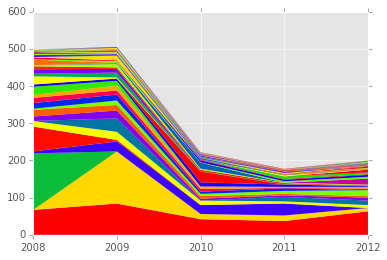

In [25]:
n_lines=40
xlims = (2008, 2012)

color.cycle_cmap(n_lines, cmap="prism")

x = dfpiv_all.columns.tolist()

fig, ax = plt.subplots()
ax.stackplot(x, dfpiv_all.loc[ordering.index.tolist()].as_matrix(), edgecolor="None")

plt.xlim(xlims)
plt.xticks(list(range(xlims[0],xlims[1] + 1)))
x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.savefig("img/diversity_sudu.png",bbox_inches='tight',dpi=100)
pass